# Implementing GARCH model for Amazon data

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
amzn = pd.read_csv("AMZN.csv")
amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn['lrets'] = (np.log(amzn.Close) - np.log(amzn.Close.shift(1))) * 100.
amzn.head()


,Date,Open,Close,High,Low,Volume,Typical_Price,lrets
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500,640.739990,NaN
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600,636.116658,-0.503631
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200,630.916667,-0.180025
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900,614.383341,-3.984119
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900,612.396668,-0.146506


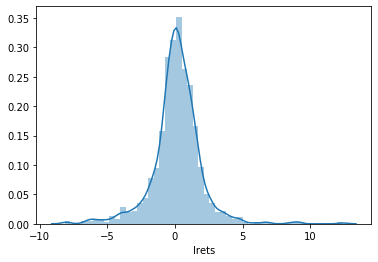

In [3]:
sns.distplot(amzn['lrets'].dropna())

In [4]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T) 
    sigma2 = np.zeros(T)   
    F = np.zeros(T)   
    v = np.zeros(T)   
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [5]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)  
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
    return Y 

         Current function value: 2.776352
         Iterations: 2
         Function evaluations: 202
         Gradient evaluations: 31


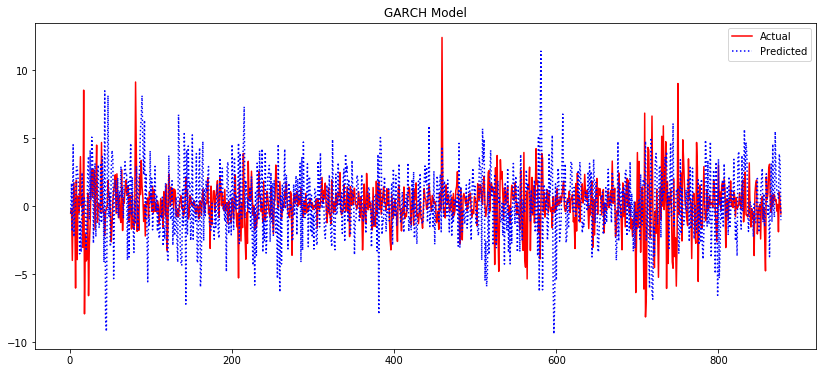

In [6]:
Y = amzn['lrets'].dropna()
T=len(Y)

param0=np.array([0.120,1.64,0.2,0.5])
param_star=minimize(GARCH,param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})
Y_GARCH=GARCH_Prod(param_star.x,Y[1],T)
timevec=np.linspace(1,T,T)

fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model")
plt.show()

In [7]:
dif = pd.DataFrame({'Actual':list(Y),
                     'Predicted':list(Y_GARCH)})




In [8]:
dif

,Actual,Predicted
0,-0.503631,-0.503631
1,-0.180025,1.688216
2,-3.984119,-1.843299
3,-0.146506,4.525282
4,1.745650,-2.248230
...,...,...
872,0.135939,1.027248
873,-1.879191,0.587999
874,1.035995,3.849887
875,0.339289,3.189249


In [9]:
dif.head()

,Actual,Predicted
0,-0.503631,-0.503631
1,-0.180025,1.688216
2,-3.984119,-1.843299
3,-0.146506,4.525282
4,1.745650,-2.248230


In [10]:
rms = sqrt(mean_squared_error(dif['Actual'],dif['Predicted']))
rms

3.129517653270506

In [11]:
y_pred = [] * 1000

for i in range(len(dif)+1):
    if i == 0:
        y_pred.append(636.989990)
    else:
        y_pred.append(math.exp(dif['Predicted'][i-1]/100) * y_pred[i-1])

In [12]:
Predicted = pd.DataFrame({'Actual_Close_Price':amzn.Close,
                     'Predicted_Close_Price':list(y_pred),
                         'Date': amzn.Date})
Predicted.set_index('Date')


,Actual_Close_Price,Predicted_Close_Price
Date,,
2016-01-04,636.989990,636.989990
2016-01-05,633.789978,633.789978
2016-01-06,632.650024,644.580552
2016-01-07,607.940002,632.807839
2016-01-08,607.049988,662.102002
...,...,...
2019-06-24,1913.900024,4459.170252
2019-06-25,1878.270020,4485.467383
2019-06-26,1897.829956,4661.519989


# Checking Return Volatility with Actual and Predicted Values


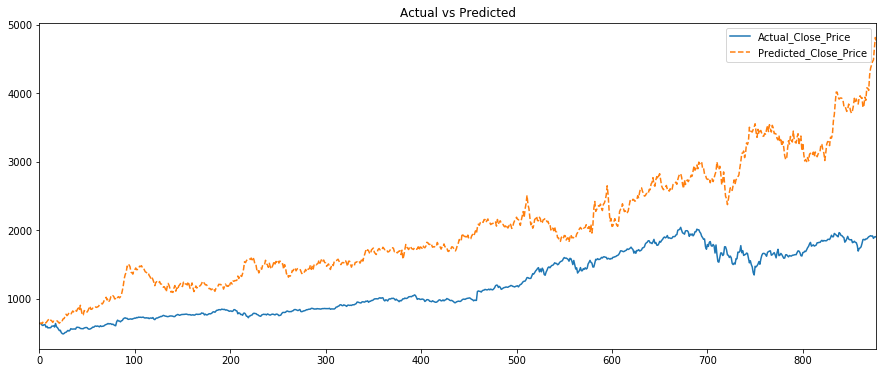

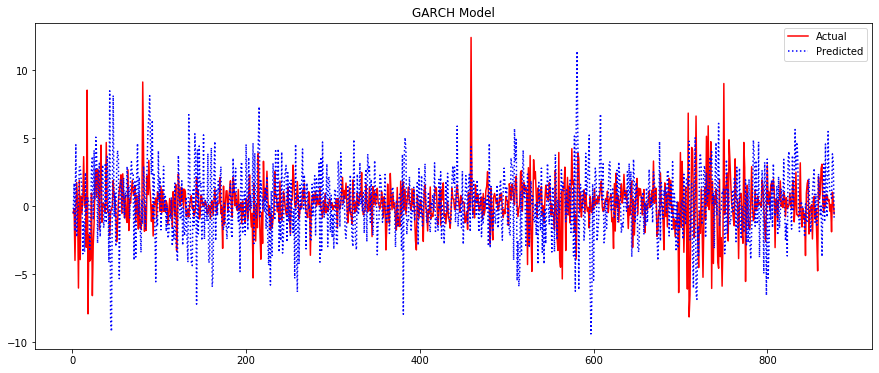

In [13]:
Predicted[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,6), style=['-','--'], 
                                                                    title = 'Actual vs Predicted')
fig= plt.figure(figsize=(15,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("GARCH Model")
plt.show()

In [14]:
Predicted.head()

,Actual_Close_Price,Predicted_Close_Price,Date
0,636.989990,636.989990,2016-01-04
1,633.789978,633.789978,2016-01-05
2,632.650024,644.580552,2016-01-06
3,607.940002,632.807839,2016-01-07
4,607.049988,662.102002,2016-01-08


# Trading Strategy
 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [15]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(Predicted)-1):
    if Predicted['Predicted_Close_Price'][i+1] > Predicted['Actual_Close_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / Predicted['Actual_Close_Price'][i])
            balance = int(amount % Predicted['Actual_Close_Price'][i])
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif Predicted['Predicted_Close_Price'][i+1] < Predicted['Actual_Close_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
 
    

Stock: 636.98999 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 633.789978 Action: Buy Portfolio: 9506.85 Stocks: 15 Balance_init: 493 total($) 9999.85


Stock: 632.650024 Action: Bought--Holding Portfolio: 9489.75 Stocks: 15 Balance_init: 493 total($) 9982.75


Stock: 607.9400019999999 Action: Bought--Holding Portfolio: 9119.1 Stocks: 15 Balance_init: 493 total($) 9612.1


Stock: 607.049988 Action: Bought--Holding Portfolio: 9105.75 Stocks: 15 Balance_init: 493 total($) 9598.75


Stock: 617.73999 Action: Bought--Holding Portfolio: 9266.1 Stocks: 15 Balance_init: 493 total($) 9759.1


Stock: 617.8900150000001 Action: Bought--Holding Portfolio: 9268.35 Stocks: 15 Balance_init: 493 total($) 9761.35


Stock: 581.8099980000001 Action: Bought--Holding Portfolio: 8727.15 Stocks: 15 Balance_init: 493 total($) 9220.15


Stock: 593.0 Action: Bought--Holding Portfolio: 8895.0 Stocks: 15 Balance_init: 493 total($) 9388.0


Stock: 570.179993 A

Stock: 725.539978 Action: Bought--Holding Portfolio: 10883.1 Stocks: 15 Balance_init: 493 total($) 11376.1


Stock: 726.72998 Action: Bought--Holding Portfolio: 10900.95 Stocks: 15 Balance_init: 493 total($) 11393.95


Stock: 723.73999 Action: Bought--Holding Portfolio: 10856.1 Stocks: 15 Balance_init: 493 total($) 11349.1


Stock: 726.6400150000001 Action: Bought--Holding Portfolio: 10899.6 Stocks: 15 Balance_init: 493 total($) 11392.6


Stock: 727.650024 Action: Bought--Holding Portfolio: 10914.75 Stocks: 15 Balance_init: 493 total($) 11407.75


Stock: 717.909973 Action: Bought--Holding Portfolio: 10768.65 Stocks: 15 Balance_init: 493 total($) 11261.65


Stock: 715.23999 Action: Bought--Holding Portfolio: 10728.6 Stocks: 15 Balance_init: 493 total($) 11221.6


Stock: 719.299988 Action: Bought--Holding Portfolio: 10789.5 Stocks: 15 Balance_init: 493 total($) 11282.5


Stock: 714.26001 Action: Bought--Holding Portfolio: 10713.9 Stocks: 15 Balance_init: 493 total($) 11206.9


Stock: 717

Stock: 746.48999 Action: Bought--Holding Portfolio: 11197.35 Stocks: 15 Balance_init: 493 total($) 11690.35


Stock: 756.400024 Action: Bought--Holding Portfolio: 11346.0 Stocks: 15 Balance_init: 493 total($) 11839.0


Stock: 760.159973 Action: Bought--Holding Portfolio: 11402.4 Stocks: 15 Balance_init: 493 total($) 11895.4


Stock: 780.0 Action: Bought--Holding Portfolio: 11700.0 Stocks: 15 Balance_init: 493 total($) 12193.0


Stock: 785.330017 Action: Bought--Holding Portfolio: 11779.95 Stocks: 15 Balance_init: 493 total($) 12272.95


Stock: 780.119995 Action: Bought--Holding Portfolio: 11701.8 Stocks: 15 Balance_init: 493 total($) 12194.8


Stock: 780.369995 Action: Bought--Holding Portfolio: 11705.55 Stocks: 15 Balance_init: 493 total($) 12198.55


Stock: 766.77002 Action: Bought--Holding Portfolio: 11501.55 Stocks: 15 Balance_init: 493 total($) 11994.55


Stock: 762.52002 Action: Bought--Holding Portfolio: 11437.8 Stocks: 15 Balance_init: 493 total($) 11930.8


Stock: 750.570007 A

Stock: 852.4600220000001 Action: Bought--Holding Portfolio: 12786.9 Stocks: 15 Balance_init: 493 total($) 13279.9


Stock: 854.590027 Action: Bought--Holding Portfolio: 12818.85 Stocks: 15 Balance_init: 493 total($) 13311.85


Stock: 852.5300289999999 Action: Bought--Holding Portfolio: 12787.95 Stocks: 15 Balance_init: 493 total($) 13280.95


Stock: 852.9699710000001 Action: Bought--Holding Portfolio: 12794.55 Stocks: 15 Balance_init: 493 total($) 13287.55


Stock: 853.419983 Action: Bought--Holding Portfolio: 12801.3 Stocks: 15 Balance_init: 493 total($) 13294.3


Stock: 852.3099980000001 Action: Bought--Holding Portfolio: 12784.65 Stocks: 15 Balance_init: 493 total($) 13277.65


Stock: 856.9699710000001 Action: Bought--Holding Portfolio: 12854.55 Stocks: 15 Balance_init: 493 total($) 13347.55


Stock: 843.2000119999999 Action: Bought--Holding Portfolio: 12648.0 Stocks: 15 Balance_init: 493 total($) 13141.0


Stock: 848.0599980000001 Action: Bought--Holding Portfolio: 12720.9 Stocks: 

Stock: 958.0 Action: Bought--Holding Portfolio: 14370.0 Stocks: 15 Balance_init: 493 total($) 14863.0


Stock: 952.4500119999999 Action: Bought--Holding Portfolio: 14286.75 Stocks: 15 Balance_init: 493 total($) 14779.75


Stock: 945.26001 Action: Bought--Holding Portfolio: 14178.9 Stocks: 15 Balance_init: 493 total($) 14671.9


Stock: 946.0200199999999 Action: Bought--Holding Portfolio: 14190.3 Stocks: 15 Balance_init: 493 total($) 14683.3


Stock: 954.0599980000001 Action: Bought--Holding Portfolio: 14310.9 Stocks: 15 Balance_init: 493 total($) 14803.9


Stock: 967.590027 Action: Bought--Holding Portfolio: 14513.85 Stocks: 15 Balance_init: 493 total($) 15006.85


Stock: 980.599976 Action: Bought--Holding Portfolio: 14709.0 Stocks: 15 Balance_init: 493 total($) 15202.0


Stock: 978.25 Action: Bought--Holding Portfolio: 14673.75 Stocks: 15 Balance_init: 493 total($) 15166.75


Stock: 965.2700199999999 Action: Bought--Holding Portfolio: 14479.05 Stocks: 15 Balance_init: 493 total($) 1497

Stock: 1209.589966 Action: Bought--Holding Portfolio: 18143.85 Stocks: 15 Balance_init: 493 total($) 18636.85


Stock: 1229.140015 Action: Bought--Holding Portfolio: 18437.1 Stocks: 15 Balance_init: 493 total($) 18930.1


Stock: 1246.869995 Action: Bought--Holding Portfolio: 18703.05 Stocks: 15 Balance_init: 493 total($) 19196.05


Stock: 1252.699951 Action: Bought--Holding Portfolio: 18790.5 Stocks: 15 Balance_init: 493 total($) 19283.5


Stock: 1254.329956 Action: Bought--Holding Portfolio: 18814.95 Stocks: 15 Balance_init: 493 total($) 19307.95


Stock: 1276.680054 Action: Bought--Holding Portfolio: 19150.2 Stocks: 15 Balance_init: 493 total($) 19643.2


Stock: 1305.199951 Action: Bought--Holding Portfolio: 19578.0 Stocks: 15 Balance_init: 493 total($) 20071.0


Stock: 1304.859985 Action: Bought--Holding Portfolio: 19572.9 Stocks: 15 Balance_init: 493 total($) 20065.9


Stock: 1295.0 Action: Bought--Holding Portfolio: 19425.0 Stocks: 15 Balance_init: 493 total($) 19918.0


Stock: 12

Stock: 1608.0 Action: Bought--Holding Portfolio: 24120.0 Stocks: 15 Balance_init: 493 total($) 24613.0


Stock: 1609.079956 Action: Bought--Holding Portfolio: 24136.2 Stocks: 15 Balance_init: 493 total($) 24629.2


Stock: 1602.910034 Action: Bought--Holding Portfolio: 24043.65 Stocks: 15 Balance_init: 493 total($) 24536.65


Stock: 1601.540039 Action: Bought--Holding Portfolio: 24023.1 Stocks: 15 Balance_init: 493 total($) 24516.1


Stock: 1576.119995 Action: Bought--Holding Portfolio: 23641.8 Stocks: 15 Balance_init: 493 total($) 24134.8


Stock: 1587.280029 Action: Bought--Holding Portfolio: 23809.2 Stocks: 15 Balance_init: 493 total($) 24302.2


Stock: 1581.76001 Action: Bought--Holding Portfolio: 23726.4 Stocks: 15 Balance_init: 493 total($) 24219.4


Stock: 1574.369995 Action: Bought--Holding Portfolio: 23615.55 Stocks: 15 Balance_init: 493 total($) 24108.55


Stock: 1585.459961 Action: Bought--Holding Portfolio: 23781.9 Stocks: 15 Balance_init: 493 total($) 24274.9


Stock: 1581.

Stock: 1987.1500239999998 Action: Bought--Holding Portfolio: 29807.25 Stocks: 15 Balance_init: 493 total($) 30300.25


Stock: 1990.0 Action: Bought--Holding Portfolio: 29850.0 Stocks: 15 Balance_init: 493 total($) 30343.0


Stock: 1989.869995 Action: Bought--Holding Portfolio: 29848.05 Stocks: 15 Balance_init: 493 total($) 30341.05


Stock: 1970.189941 Action: Bought--Holding Portfolio: 29552.85 Stocks: 15 Balance_init: 493 total($) 30045.85


Stock: 1908.030029 Action: Bought--Holding Portfolio: 28620.45 Stocks: 15 Balance_init: 493 total($) 29113.45


Stock: 1941.050049 Action: Bought--Holding Portfolio: 29115.75 Stocks: 15 Balance_init: 493 total($) 29608.75


Stock: 1926.4200440000002 Action: Bought--Holding Portfolio: 28896.3 Stocks: 15 Balance_init: 493 total($) 29389.3


Stock: 1944.300049 Action: Bought--Holding Portfolio: 29164.5 Stocks: 15 Balance_init: 493 total($) 29657.5


Stock: 1915.0100100000002 Action: Bought--Holding Portfolio: 28725.15 Stocks: 15 Balance_init: 493 to

Stock: 1659.420044 Action: Bought--Holding Portfolio: 24891.3 Stocks: 15 Balance_init: 493 total($) 25384.3


Stock: 1656.219971 Action: Bought--Holding Portfolio: 24843.3 Stocks: 15 Balance_init: 493 total($) 25336.3


Stock: 1640.560059 Action: Bought--Holding Portfolio: 24608.4 Stocks: 15 Balance_init: 493 total($) 25101.4


Stock: 1617.209961 Action: Bought--Holding Portfolio: 24258.15 Stocks: 15 Balance_init: 493 total($) 24751.15


Stock: 1674.560059 Action: Bought--Holding Portfolio: 25118.4 Stocks: 15 Balance_init: 493 total($) 25611.4


Stock: 1683.780029 Action: Bought--Holding Portfolio: 25256.7 Stocks: 15 Balance_init: 493 total($) 25749.7


Stock: 1693.219971 Action: Bought--Holding Portfolio: 25398.3 Stocks: 15 Balance_init: 493 total($) 25891.3


Stock: 1696.199951 Action: Bought--Holding Portfolio: 25443.0 Stocks: 15 Balance_init: 493 total($) 25936.0


Stock: 1632.170044 Action: Bought--Holding Portfolio: 24482.55 Stocks: 15 Balance_init: 493 total($) 24975.55


Stock:

Stock: 1836.430054 Action: Bought--Holding Portfolio: 27546.45 Stocks: 15 Balance_init: 493 total($) 28039.45


Stock: 1819.189941 Action: Bought--Holding Portfolio: 27287.85 Stocks: 15 Balance_init: 493 total($) 27780.85


Stock: 1816.319946 Action: Bought--Holding Portfolio: 27244.8 Stocks: 15 Balance_init: 493 total($) 27737.8


Stock: 1775.069946 Action: Bought--Holding Portfolio: 26626.05 Stocks: 15 Balance_init: 493 total($) 27119.05


Stock: 1692.689941 Action: Bought--Holding Portfolio: 25390.35 Stocks: 15 Balance_init: 493 total($) 25883.35


Stock: 1729.560059 Action: Bought--Holding Portfolio: 25943.4 Stocks: 15 Balance_init: 493 total($) 26436.4


Stock: 1738.5 Action: Bought--Holding Portfolio: 26077.5 Stocks: 15 Balance_init: 493 total($) 26570.5


Stock: 1754.359985 Action: Bought--Holding Portfolio: 26315.4 Stocks: 15 Balance_init: 493 total($) 26808.4


Stock: 1804.030029 Action: Bought--Holding Portfolio: 27060.45 Stocks: 15 Balance_init: 493 total($) 27553.45


Stock

# Created a dataframe with all the information 

In [16]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,633.789978,633.789978,2016-01-05,Price-Prediction-Already-Lower,0,0.00000,10000.0
2,632.650024,644.580552,2016-01-06,Buy,15,9506.84967,10000.0
3,607.940002,632.807839,2016-01-07,Bought--Holding,15,9489.75036,9983.0
4,607.049988,662.102002,2016-01-08,Bought--Holding,15,9119.10003,9612.0
5,617.739990,647.382510,2016-01-11,Bought--Holding,15,9105.74982,9599.0


# Profit Made with this Strategy

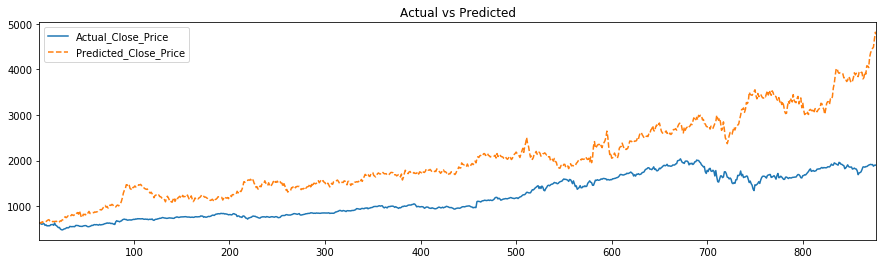

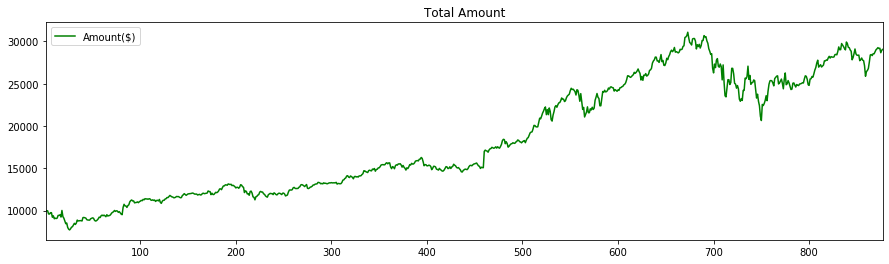

In [17]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [18]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')


Initial_Investment : 10000$
Final Amount: 29057.0 $
Profit_Percent: 290.57 %


In [19]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))
rms

963.5285127807379

# Sharp Ratio

In [20]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()



In [21]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio


0.0013746195306495767 0.017722886942349497


2.2969304212982182

In [22]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [23]:
sqrt(rms)

31.04075567348092